#Project Dissertation (CI7000_A_SPAN1_21)

##Deep Learning


---


*    Ladan Saeidi - K2145352


# Making Recommendation System using Keras

Movielens-100k dataset will be used in this code. 

In [ ]:
# Import libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import keras
from IPython.display import SVG
from tensorflow.keras.optimizers import Adam
from keras.layers import dot
from keras.utils.vis_utils import model_to_dot
from keras.layers import merge
import tensorflow as tf


%matplotlib inline

In [ ]:
# Read data
dataset = pd.read_csv ("https://raw.githubusercontent.com/singhsidhukuldeep/Recommendation-System/master/data/ratings.csv")

In [ ]:
# Find the information about dataset
# There is no null value the in the dataset
# It has 100,836 Rows and 4 Columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
# Look at the 5 first rows of the dataset
dataset.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Find the number of user id and movie id in the dataset
# Dataset has 610 unique users and 9724 unique movies
len(dataset.userId.unique()), len(dataset.movieId.unique())

(610, 9724)

In [ ]:
# Categorized each of variables into numbers 
# Return Series of codes as well as the index
dataset.userId = dataset.userId.astype('category').cat.codes.values
dataset.movieId = dataset.movieId.astype('category').cat.codes.values

In [ ]:
dataset.movieId

0            0
1            2
2            5
3           43
4           46
          ... 
100831    9416
100832    9443
100833    9444
100834    9445
100835    9485
Name: movieId, Length: 100836, dtype: int16

In [ ]:
# Look at the dataframe again
dataset.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,43,5.0,964983815
4,0,46,5.0,964982931


In [ ]:
# Split data to train and test
# 80% for train and 20% for test
train, test = train_test_split(dataset, test_size=0.2)

In [ ]:
train.head()

,userId,movieId,rating,timestamp
70226,447,8398,2.0,1440358879
47774,307,3867,3.5,1421375233
66351,426,4023,3.0,1053069946
37182,248,7829,3.0,1347887198
14374,90,1370,3.0,1112716494


In [ ]:
test.head()


,userId,movieId,rating,timestamp
72364,465,6726,4.0,1439915324
90563,589,334,3.0,1258420459
6196,41,2340,5.0,996218785
56932,379,322,5.0,1493474112
88904,572,6360,3.0,1186589452


## Matrix Factorisation in Keras

In [ ]:
# Allocate Variables for the number of users and movies
# Let's say latent factors is equla to 3
number_unique_users, number_unique_movies = len(dataset.userId.unique()), len(dataset.movieId.unique())
number_latent_factors = 3

Learning an embedding for movies and users is the main point here, then we can merge them together using the dot product. Our two dimensions in user embedding are [how much user likes action, how much user likes long movies], and in item embedding are [how much action is in the movie, how long is the movie].  

Then, we can predict for a user u, and movie m as how much u likes action × how much action is there in m + how much u likes long movies × how long is m.

In [ ]:
# learning embeddings for user and item
# use dot product(two vectors)
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(number_unique_movies + 1, number_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(number_unique_users + 1, number_latent_factors,name='User-Embedding')(user_input))


product = dot([movie_vec, user_vec], axes=1)


model = keras.Model([user_input, movie_input], product)
model.compile('adam', 'mean_squared_error')

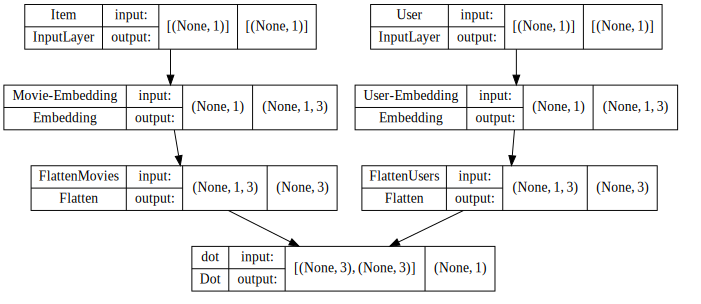

In [ ]:
# Visualize the model to a better understanding
# use dpi to control the size of visualization
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB',dpi=70).create(prog='dot', format='svg'))
# show_layer_names: whether to display layer names
# show_shapes: whether to display shape information
# rankdir: rankdir argument passed to PyDot, a string specifying the format of the plot: 'TB' creates a vertical plot; 'LR' creates a horizontal plot.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 3)         29175       ['Item[0][0]']                   
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 3)         1833        ['User[0][0]']                   
                                                                                              

In [ ]:
# Fit the model (Train the model)
history = model.fit([train.userId, train.movieId], train.rating, epochs=100, verbose=0)

## Plotting the Train Loss

Text(0, 0.5, 'Train Error')

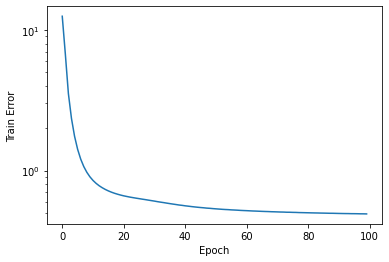

In [ ]:
# visualise the train loss with epoch number
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [ ]:
# Round off our prediction to the nearest integer (one-hot encoding)
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

## Evaluation Metrics

In [ ]:
# Calculate evaluation metric MAE
mean_absolute_error(y_true, y_hat).round(4)

0.7927

In [ ]:
# Calculate evaluation metric RMSE
rmse = mean_squared_error(y_true, y_hat , squared=False).round(4)
rmse

1.1685

## Neural Networks for Recommendation System

The differences between this new model and the previous one are to concatenate the user and item embedding and use them as features of the neural network instead of using the dot product. In this situation, we can have various dimensions for the item and user embedding which is helpful when one dimension is larger than the other one.

In [ ]:
# Let's say the number of laten user factors is 5
# Let's say the number of laten movie factors is 8
number_latent_factors_user = 5
number_latent_factors_movie = 8

It should be noted that we use a different number of embeddings for user (3) and items (5)! These combine to form a vector of length (5+3 = 8), which is then fed into the neural network. We also add a dropout layer to prevent overfitting!

* **dropout:** This layer will drop the activations with given probability parameter. The activations have p1, p2 probabilities to be turned to 0. This is done to reduce overfitting.

* **embedding:** This layer creates a lookup table for embeddings corresponding to unique users and unique movies. The values in this layer are updated by back-propagation.


In [ ]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(number_unique_movies + 1, number_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(number_unique_users + 1, number_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = tf.keras.layers.Concatenate()([movie_vec, user_vec])
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

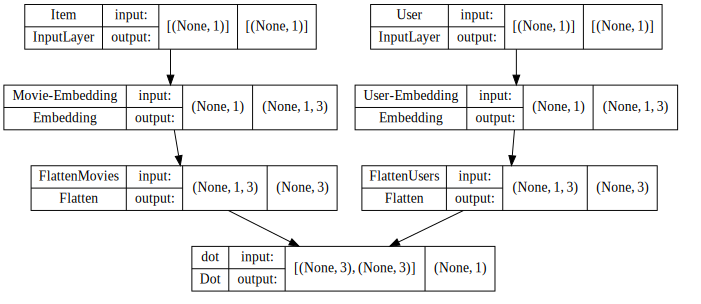

In [ ]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB', dpi=70).create(prog='dot', format='svg'))

We can see that the number of parameters is more than what we had in the Matrix Factorisation case. Let's see how this model works. I'll run it for more epochs given that we have more parameters

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 3)         29175       ['Item[0][0]']                   
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 3)         1833        ['User[0][0]']                   
                                                                                              

In [ ]:
# Fit the model
history = model.fit([train.userId, train.movieId], train.rating, epochs=250, verbose=0)

## Evaluation Metrics

Pretty similar to the result we got using matrix factorisation

In [ ]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
# print(mean_absolute_error(y_true, y_hat))
# print(mean_absolute_error(y_true, model.predict([test.userId, test.movieId])))

print(f'MAE is {mean_absolute_error(y_true, model.predict([test.userId, test.movieId]))}' )

MAE is 0.8246419256870393


In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_true, y_hat , squared=False)
print(f'RMSE is {rmse}')

RMSE is 1.229033806524591


# Plotting the Results for Comparison (RMSE)

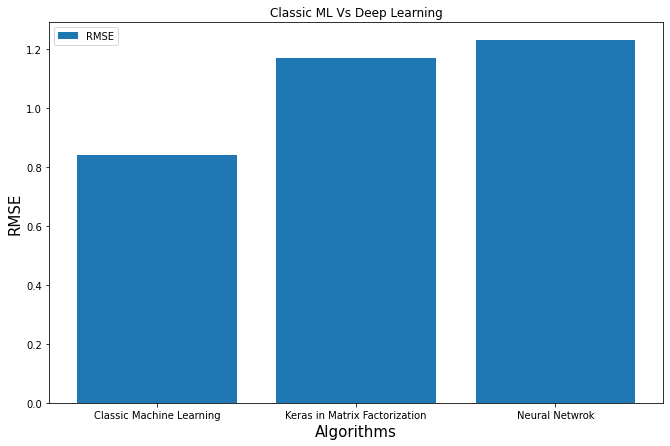

In [ ]:
# Plotting the results for comparison (RMSE)

x= ['Classic Machine Learning', 'Keras in Matrix Factorization', 'Neural Netwrok']
y=[0.9354, 1.1685 , 1.2290]

plt.figure(figsize=[11, 7])

plt.bar(x, y, label = 'RMSE')


plt.xlabel("Algorithms",fontsize=15)
plt.ylabel("RMSE",fontsize=15)
plt.title("Classic ML Vs Deep Learning")
plt.legend()
plt.show()

# Plotting the Results for Comparison (MAE)

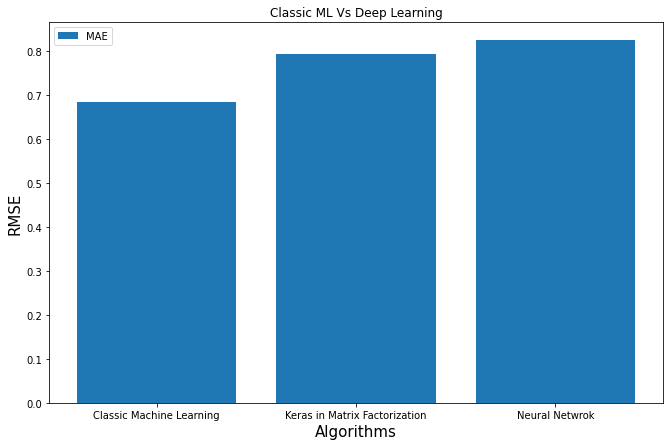

In [ ]:
# Plotting the results for comparison (MAE)

x= ['Classic Machine Learning', 'Keras in Matrix Factorization', 'Neural Netwrok']
y=[0.6854, 0.7927 , 0.8246]

plt.figure(figsize=[11, 7])

plt.bar(x, y, label = 'MAE')


plt.xlabel("Algorithms",fontsize=15)
plt.ylabel("MAE",fontsize=15)
plt.title("Classic ML Vs Deep Learning")
plt.legend()
plt.show()

# Plotting the Comparison of RMSE and MAE - Classic Machin Learning Vs Deep Learning

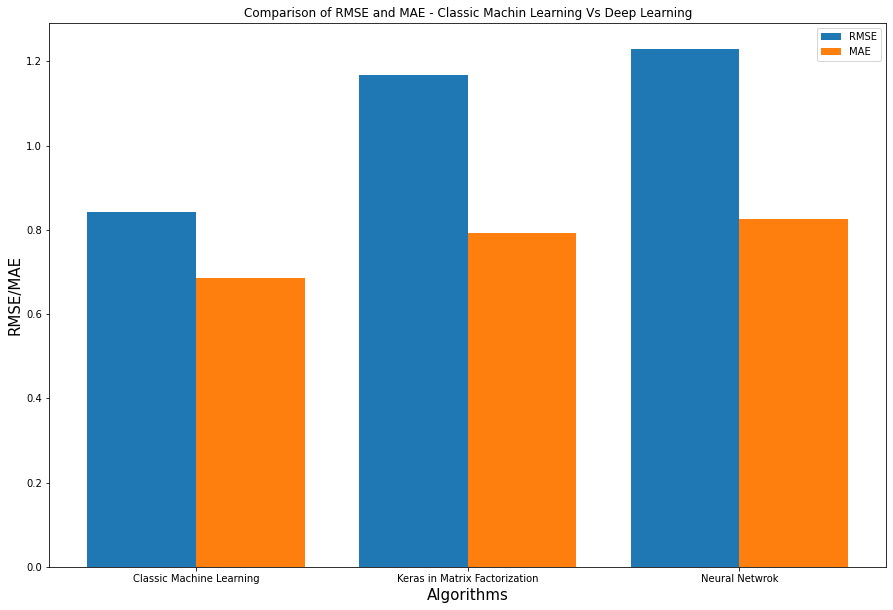

In [ ]:
X = ['Classic Machine Learning', 'Keras in Matrix Factorization', 'Neural Netwrok']
rmse = [0.841514, 1.1685 , 1.2290	]
mae = [0.6854, 0.7927 , 0.8246]
plt.figure(figsize=[15, 10])
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, rmse, 0.4, label = 'RMSE')
plt.bar(X_axis + 0.2, mae, 0.4, label = 'MAE')


plt.xticks(X_axis, X)
plt.xlabel("Algorithms",fontsize=15)
plt.ylabel("RMSE/MAE",fontsize=15)
plt.title("Comparison of RMSE and MAE - Classic Machin Learning Vs Deep Learning")
plt.legend()
plt.show()

# References
* The above code adopted from this link, and used in this implementation by making some changes. All figures' codes and results are written from scratch.

https://nipunbatra.github.io/blog/ml/2017/12/18/recommend-keras.html